In [35]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
import keras
!pip install scikeras
import scikeras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier




[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



### Import CSV and transform 

In [3]:

df = pd.read_csv("F:\Git\Food-price-forecast\ModelsAndDatasets\Datasets\price_temp_grain_starch.csv")
df = df.drop(columns=["Unnamed: 0"])   #Lösche unnötige Spalte
df.index = pd.to_datetime(df['Date'], format = '%Y-%m') #Datum als Index
df = df[df.Date <= "2021-12-01"]  #Alles vor 2022
df = df.drop(columns=["Date"], axis = 1)
df

,Food_Price,Air_Temperature,grain_starch_output_price
Date,,,
1996-01-01,74.9,-2.82,87.3
1996-02-01,75.5,-2.18,87.4
1996-03-01,76.1,1.00,87.7
1996-04-01,76.4,8.40,87.8
1996-05-01,76.2,11.15,88.8
...,...,...,...
2021-08-01,114.2,16.40,107.2
2021-09-01,114.2,15.16,108.2
2021-10-01,114.2,9.63,112.8


In [4]:
ss = StandardScaler()
df = pd.DataFrame(ss.fit_transform(df),columns = df.columns)
df

,Food_Price,Air_Temperature,grain_starch_output_price
0,-1.255570,-1.876104,-0.671747
1,-1.205758,-1.777546,-0.662489
2,-1.155946,-1.287835,-0.634715
3,-1.131040,-0.148257,-0.625457
4,-1.147644,0.275235,-0.532876
...,...,...,...
307,2.007114,1.083720,1.170617
308,2.007114,0.892763,1.263198
309,2.007114,0.041160,1.689072
310,2.056926,-0.687246,1.911266


### Plot Food-Price

<Axes: >

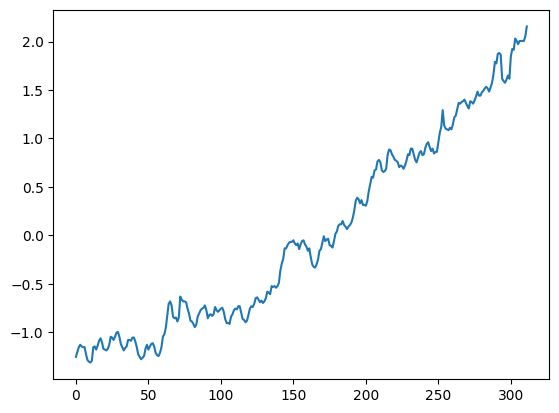

In [5]:
price = df["Food_Price"]
price.plot()


### Erstelle Sliding-Window Arrays

In [6]:
def df_to_X_y(df, window_size=5): #gebe DataFrame und Zeitraum der zu berücksichtigenden Perioden für Vorhersage an 
    df_as_np = df.to_numpy()
    X = [] # Vergangene Werte für Vorhersage
    y = [] # Labels für zu vorhersagende Periode

    for i in range(len(df_as_np)-window_size): #Iteration über numpy-Liste der Werte abzüglich window size
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)          #Gebe Zeitreihe für X und y zurück

#### Überprüfe Format 

In [7]:
window = 9
X, y = df_to_X_y(df, window)
X.shape, y.shape

((303, 9, 3), (303,))

#### Erstelle Test-Train Split

In [8]:
X_train, y_train = X[:250], y[:250]
X_val, y_val = X[250:275], y[250:275]
X_test, y_test = X[275:], y[275:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  #Überprüfufe Form der Splits

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

## Model-Definition & Training

### Erstelle LSTM-Model with Tensorflow

In [60]:
np.random.seed = 42

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adagrad

#definiere Model als Function für GridSearch

def define_model(optimizer ="Adam"):
    model7 = Sequential()
    model7.add(LSTM(64, activation='relu', input_shape=(window, 3), return_sequences=True))
    model7.add(LSTM(32, activation='relu', return_sequences=False))
    model7.add(Dropout(0.1))
    model7.add(Dense(1))

    model7.compile(optimizer=optimizer, loss='mape', metrics=["mape"])
    
    return model7



### Grid-Search

In [61]:
from scikeras.wrappers import KerasRegressor
batch_size = 32
epochs = 300

model = KerasRegressor(
                       build_fn=define_model,
                       epochs=epochs,
                       batch_size=batch_size,                     
                       verbose=1)

optimizer = ['SGD', 'RMSprop', 'Adagrad']

param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs = 8, cv= 3)

grid_result = grid.fit(X_train, y_train)



Epoch 1/300


f:\Git\Food-price-forecast\venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 2s 6ms/step - loss: 96.6503 - mape: 96.6503
Epoch 2/300
8/8 [==============================] - 0s 5ms/step - loss: 90.7156 - mape: 90.7156
Epoch 3/300
8/8 [==============================] - 0s 6ms/step - loss: 80.6290 - mape: 80.6290
Epoch 4/300
8/8 [==============================] - 0s 6ms/step - loss: 70.7468 - mape: 70.7468
Epoch 5/300
8/8 [==============================] - 0s 6ms/step - loss: 53.5164 - mape: 53.5164
Epoch 6/300
8/8 [==============================] - 0s 6ms/step - loss: 39.9844 - mape: 39.9844
Epoch 7/300
8/8 [==============================] - 0s 6ms/step - loss: 34.7725 - mape: 34.7725
Epoch 8/300
8/8 [==============================] - 0s 5ms/step - loss: 27.0652 - mape: 27.0652
Epoch 9/300
8/8 [==============================] - 0s 5ms/step - loss: 26.8283 - mape: 26.8283
Epoch 10/300
8/8 [==============================] - 0s 5ms/step - loss: 27.6889 - mape: 27.6889
Epoch 11/300
8/8 [==============================] - 0s 5ms/st

In [62]:
print(grid_result.best_score_,grid_result.best_params_)

-1.0378617206214598 {'optimizer': 'SGD'}


### Anweisung, dass nur bestes Modell nach Training gespeichert werden soll

In [10]:

cp3 = ModelCheckpoint("model3/", save_best_only = True) #Speichere nur bestes Modell mit niedrigstem MeanSqúaredError
model3.compile(loss="mape", optimizer=Adam(learning_rate=0.001), metrics=["mape"])

### Model Training mit Training und Validation Dataset

In [22]:
model3.fit(X_train, y_train, epochs=600, validation_data = (X_val,y_val), batch_size=32, verbose=0, callbacks=[cp3]).history

{'loss': [11.205604553222656,
  11.695130348205566,
  11.928877830505371,
  11.618646621704102,
  11.465767860412598,
  10.641228675842285,
  11.495437622070312,
  11.125758171081543,
  11.650053977966309,
  10.276718139648438,
  10.705705642700195,
  10.302032470703125,
  11.29349422454834,
  10.577154159545898,
  11.173392295837402,
  11.028913497924805,
  11.370530128479004,
  11.009692192077637,
  11.848738670349121,
  10.984663009643555,
  11.394800186157227,
  11.86867618560791,
  10.97826862335205,
  10.336791038513184,
  10.427927017211914,
  11.595281600952148,
  10.98937702178955,
  12.034977912902832,
  11.143880844116211,
  11.758636474609375,
  10.462063789367676,
  11.389012336730957,
  11.425236701965332,
  10.283557891845703,
  9.589737892150879,
  10.580254554748535,
  10.693870544433594,
  9.95826530456543,
  11.31137752532959,
  10.791156768798828,
  10.119611740112305,
  11.58794116973877,
  11.313575744628906,
  11.34640884399414,
  10.312507629394531,
  10.6013011

### Lade beste Modelle aus Training

In [12]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')


## Vorhersage & Performance



Training-MAPE 10.90054702758789
Validation-MAPE 4.76428747177124
Test-MAPE 8.326123237609863


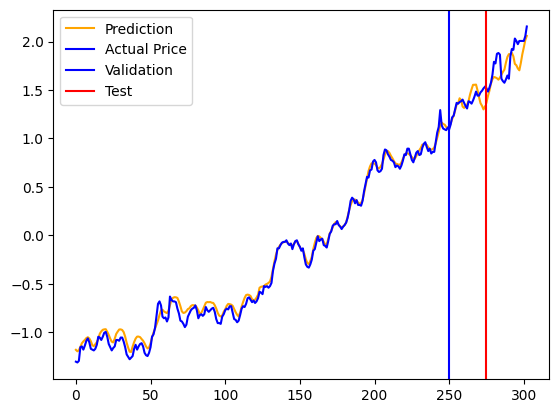

In [21]:
plt.plot(train_results['Train Predictions'],label='Prediction', color = "orange")
plt.plot(train_results['Actuals'],label='Actual Price', color = "b")
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Validation Predictions'],color = 'orange')
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Actuals'], color = "b")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Test Predictions'], color = "orange")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Actuals'],color = "b")
plt.axvline(x = 250, color = 'b', label = 'Validation')
plt.axvline(x = 275, color = 'r', label = 'Test')
plt.legend()
plt.legend()

print(f"Training-MAPE {tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])}")
print(f"Validation-MAPE {tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])}")
print(f"Test-MAPE {tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])}")


### Training Data-Set isolierte Ansicht

In [13]:
train_predictions = model3.predict(X_train).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
train_results = pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals': y_train}) 
train_results

tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])  #Mean Absolute percentage Error

8/8 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=10.900547>

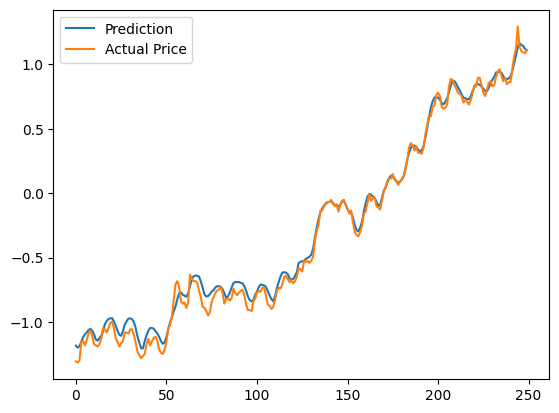

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'],label='Prediction')
plt.plot(train_results['Actuals'],label='Actual Price')
plt.legend()



### Validation Data-Set islolierte Ansicht

In [15]:
val_predictions = model3.predict(X_val).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions,'Actuals': y_val}) 
val_results

tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])

1/1 [==============================] - 0s 22ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=4.7642875>

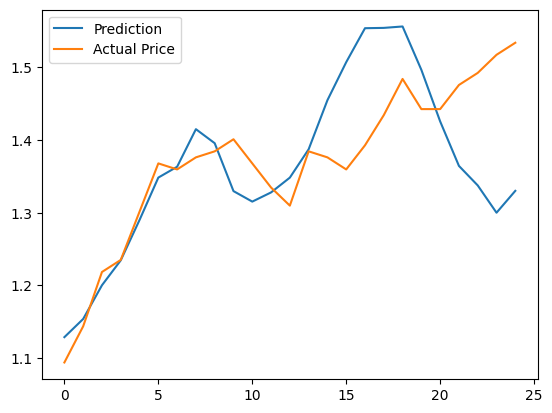

In [16]:
plt.plot(val_results['Validation Predictions'],label='Prediction')
plt.plot(val_results['Actuals'],label='Actual Price')
plt.legend()


### Test Data-Set isolierte Ansicht

In [17]:
test_predictions = model3.predict(X_test).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
test_results = pd.DataFrame(data={'Test Predictions':test_predictions,'Actuals': y_test}) 
test_results

tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=8.326123>

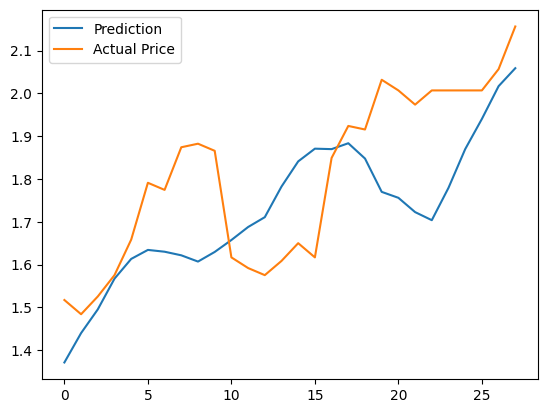

In [18]:
plt.plot(test_results['Test Predictions'],label='Prediction')
plt.plot(test_results['Actuals'],label='Actual Price')
plt.legend()
